## import module

In [8]:
import numpy as np
from math import copysign
import matplotlib.pyplot as plt
from tqdm import tqdm
from missile_gym import MissileGym
import pickle

In [9]:
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

## options

In [10]:
opts = {
    'm_0': 150,
    'vel_abs': 800,
    't': 3,
    'w': 60,
    'P': 40e3,
    'I': 2450,
    'dt': 0.05,
    'tau': 1/10,
    't_max': 25,
    'r_kill': 25,
    'alpha_max': 15,
    'am': 5,
    'a': 0.2,
    'd': 0.2,
    'init_conditions': {'V_0': 30, 'pos_0': (0, 25)},
}

## function

In [11]:
def mass_minimize(combination, mis_opts, trg_pos, trg_vel):
    
    thrust, t = combination
    omega = thrust * t / I_1

    mis_opts['m_0'] = omega + m
    mis_opts['t'] = t
    mis_opts['w'] = omega
    mis_opts['P'] = thrust
    mis_opts['I'] = I_1

    gym = MissileGym.make_simple_scenario(mis_opts, trg_pos, trg_vel)
    
    vel_array = []
    done = False  
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        vel_array.append(float(gym.missile.get_summary()['v']))
    
    vel_max = np.max(vel_array) 
    vel_abs = np.mean(vel_array)    
    inf = info['done_reason']
    mis_smry = gym.missile.get_summary()    
    etta = thrust / (mis_opts['m_0'] * 9.80665)
    
    # P, t_act, m_0, w, inf, etta, x, y, t, v_max, v_mean
    return np.array([thrust,
                     t,
                     mis_opts['m_0'],
                     omega,
                     inf,
                     etta,
                     mis_smry['x'],
                     mis_smry['y'],
                     mis_smry['t'],
                     mis_smry['v'],
                     vel_max,
                     vel_abs])

In [12]:
I_1 = 2700
m = 90
trg_pos = (18e3, 10e3)
trg_vel = (0, 0)

## variable options

In [13]:
thrusts = np.linspace(5e3, 35e3, 40)
ts_act = np.linspace(5, 15, 40)

In [14]:
# через распараллеливание процесса на ядра
from joblib import Parallel, delayed

combinations = []
for i in range(len(thrusts)):
    for j in range(len(ts_act)):
        combination = thrusts[i], ts_act[j]
        combinations.append(combination)
        
out = Parallel(n_jobs=12, verbose=10)(delayed(mass_minimize)(combination, opts, trg_pos, trg_vel) for combination in combinations)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   17.8s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   33.4s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   49.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

In [15]:
with open('saves/mass_minimize.bin', 'wb') as f:
    pickle.dump(out, f)

## vizualizing

In [16]:
with open('saves/mass_minimize.bin', 'rb') as f:
    res_hit = pickle.load(f)

In [17]:
mass_max = 165
vel_max = 1200
vel_mean = 900
etta_max = 15

arr1_thrust = []
arr1_t_act = []
arr2_thrust = []
arr2_t_act = []
arr3_thrust = []
arr3_t_act = []
arr4_thrust = []
arr4_t_act = []
arr5_thrust = []
arr5_t_act = []
arr5_w = []
arr5_v_abs = []
 # P, t_act, m_0, w, inf, etta, x, y, t, v_max, v_mean
for i in range(len(res_hit)):
        
    if float(res_hit[i][2]) > mass_max:
        arr2_thrust.append(float(res_hit[i][0]))
        arr2_t_act.append(float(res_hit[i][1]))
    elif float(res_hit[i][5]) > etta_max:
        arr3_thrust.append(float(res_hit[i][0]))
        arr3_t_act.append(float(res_hit[i][1]))
    elif float(res_hit[i][-2]) < vel_max:
        arr4_thrust.append(float(res_hit[i][0]))
        arr4_t_act.append(float(res_hit[i][1]))
#     elif float(res_hit[i][-1]) < vel_mean:
#         arr6_thrust.append(float(res_hit[i][0]))
#         arr6_t_act.append(float(res_hit[i][1]))
    else:
        arr5_thrust.append(float(res_hit[i][0]))
        arr5_t_act.append(float(res_hit[i][1]))
        arr5_w.append(float(res_hit[i][3]))
        arr5_v_abs.append(float(res_hit[i][-1]))

In [18]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

pubu_r = cm.get_cmap('PuBu_r', 256)
newcolors = pubu_r(np.linspace(0.01, 1, 256))
newcolors[:25, :] = cm.get_cmap('winter_r', 100)(np.linspace(0.1, 0.35, 25))
newcmp = ListedColormap(newcolors)

In [19]:
omega = np.min(arr5_w) 
ind = np.argmin(arr5_w)
thrust = arr5_thrust[ind]
t = arr5_t_act[ind] 
v_abs = arr5_v_abs[ind]
opts['m_0'] = omega + m
opts['t'] = t
opts['w'] = omega
opts['P'] = thrust
opts['I'] = I_1
opts['vel_abs'] = v_abs

In [20]:
thrust / (opts['m_0'] * 9.80665) # тяговооруженность ДУ

13.623969972920568

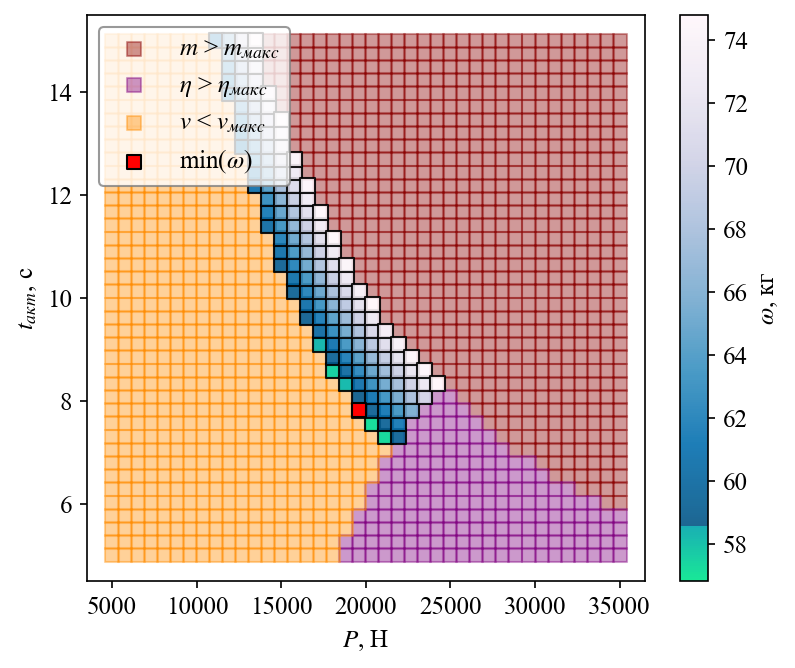

In [31]:
fontsize = 12
s = 50
alpha = 0.4
# -----------------------------------------
fig = plt.figure(figsize=(6,5), dpi=150)
# -----------------------------------------
plt.scatter(arr2_thrust, arr2_t_act,
            marker = 's',
            color = 'darkred',
            label = '$m$ > $m_{макс}$',
            s = s,
            alpha = alpha)
plt.scatter(arr3_thrust, arr3_t_act,
            marker = 's',
            color = 'purple',
            label = r'$\eta$ > $\eta$$_{макс}$',
            s = s,
            alpha = alpha)
plt.scatter(arr4_thrust, arr4_t_act,
            marker = 's',
            color = 'darkorange',
            label = '$v$ < $v_{макс}$',
            s = s,
            alpha = alpha)
# -----------------------------------------
ax = plt.scatter(arr5_thrust, arr5_t_act, c=arr5_w,
                 cmap=newcmp,
                 edgecolor='k',
                 marker = 's',
                 s = s,
                 alpha = 0.9)
cb = plt.colorbar(ax)
cb.set_label('$\omega$, кг', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
cb.ax.locator_params(nbins=10)
# -----------------------------------------
plt.scatter(thrust,
            t,
            marker = 's',
            color = 'r',
            edgecolor='k',
            label = 'min($\omega$)',
            s = s)
# -----------------------------------------
plt.tick_params(labelsize=fontsize)
plt.ylabel('$t_{акт}$, с', fontsize=fontsize)
plt.xlabel('$P$, Н', fontsize=fontsize)
plt.legend(loc=2,
           fontsize = 12,
#            bbox_to_anchor=(.98, .98),
           edgecolor ='grey')
# -----------------------------------------
plt.savefig('pictures/Обратная_задача_стартовая ДУ.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
with open('saves/opts.bin', 'wb') as f:
    pickle.dump(opts, f)